# Variational eigenvector continuation for potential energy surface learning

## The idea in a nutshell
Assuming we have access to very few computationally intensive calculations to approximate physical quantities (such as the energy) for given molecular systems, the main goal is to find ways to extrapolate such descriptions beyond few "training" setups in a rigorous way across the full manifold of molecular geometries.
This would, e.g. allow us to describe the full potential energy surface and the force field for molecular dynamics or structure search.
The goal is very similar to standard approaches extracting the force fields from few DFT calculations using machine learning machinery, typically relying on finding a suitable representation of the atomic configuration of the molecular structure.
However, we aim to do the generalization of the quantities directly on the wavefunction level, in which we infer a full description of the quantum state at each molecular geometry from wavefunctions obtained for the few training geometries.
Leaving aside the problem of how to define/find the state representation at the training points (for which we can use different common wavefunction ansatzes, such as selected CI, MPS, or our own state representation - Gaussian Process States), we can efficiently construct a sensible wavefunction at each test point as a linear combination from the states at the training geometries.
Crucially, this linear combination can easily be obtained in an analytic closed form, and evaluations of energy/force expectation values at new test points can be obtained relatively cheaply from pre-computed quantities, not requiring a naive evaluation of expectation values for this state.
With the wavefunction based approach, we particularly target the small system but very high accuracy limit, for systems where DFT/Hartree-Fock approaches are not suitable (but Hartree-Fock is considered to be cheap).
Most importantly, our wavefunction-based approach is fully variational, always guaranteeing an upper bound on the exact ground state energy at each evaluation point, which likely also has benefits for the computation of force-fields (though that remains to be tested at this stage).

## Making things a bit more concrete - the details
For a fixed nuclear geometry, we can write the electronic structure Hamiltonian in second quantization according to (glossing over the spin-dependency details)
$$
\hat{H} = \sum_{i,j} h^{(1)}_{a,b} \hat{c}^\dagger_{a} \hat{c}_{b} + \frac{1}{2}\sum_{a,b,c,d} h^{(2)}_{a,b,c,d} \hat{c}^\dagger_{a} \hat{c}^\dagger_{b} \hat{c}_{c}  \hat{c}_{d}.
$$
For this representation of the problem, we make use of a set of $L$ molecular orbitals as Fermionic modes with associated annihilation/creation operators $\hat{c}^{(\dagger)}$.
We generally obtain the molecular orbitals by an appropriate orthogonalization of a chosen atomic orbital basis set with standard approaches (more on that below...).
The chosen molecular orbitals fully define the one- and two electron integral prefactors, $h^{(1)}$ and $h^{(2)}$, of the Hamiltonian incorporating the kinetic single-electron contributions and the electron-electron interactions from the Coulomb repulsion in the chosen basis.
Setting up the problem in this way generally scales as $O[L^5]$, in-line with a Hartree-Fock calculation.

Having defined the Hamiltonian as above, we can solve for the electronic ground state, $|\Psi\rangle$, at a defined nuclear geometry.
In order to break the exponential scaling of the underlying problem, we ultimately want to use (approximate) representations of the FCI wavefunction (MPS, selected CI, GPS), but the specifics of the ansatz are not (yet) really important for the general approach (though practically each representation will come with some restrictions of its applicability).

Having performed a few (computationally expensive) calculations to get the ground state of the system for some given nuclear geometries (our training points), we want to sample from the potential energy surface/force field without having to repeat an expensive diagonalisation of the Hamiltonian at each sample/test geometry.
To this end, we represent the ground state of the system at each test point as a linear combination of the ground state (approximations) we obtained for the training geometries.
Crucially, we project the eigenvalue problem into the Hilbert space spanned by the few training states, from which we can obtain the linear expansion coefficients, as well as an energy estimate in closed form easily.

In order to utilize the training wavefunctions efficiently, this procedure involves one rather non-straightforward step.
Whereas a first quantized representation can be defined consistently across multiple atomic geometries (as long as we have the same number of electrons, the state always lives in the same Hilbert space), in the second quantized space, the basis to construct the problem actually changes with the nuclear geometry (as the molecular orbitals change).
This means that each of the training states refers to a different basis and we need to define how we can re-use the state from one geometry for a different geometry, even though the basis is different.
The way we do this is probably the most naive approach one can think of - we simply reinterpret a state, originally optimized for different molecular orbitals, in the new basis by assuming the same wavefunction amplitudes across the computational basis.
This is possible as the Fock spaces of the electronic occupancies in which we solve the Schroedinger equation are the same - even though the electrons might occupy different molecular orbitals used to set up the problem.
While this requires a certain degree of consistency across the definition of the molecular orbitals ("the basis") across different molecular arrangements, this works surprisingly well for some basis choices.
More on that is discussed below, let's first formalize this approach a bit more. 

### Getting a ground state approximation at a test point from a generalized eigenvalue problem

Given few training geometries, we set up the Hamiltonian as specified above and find an (approximate) description of the ground state. For this approximation, we might e.g. use DMRG, selected CI, but we can exemplify the approach for now with an FCI calculation.
This gives us as set of $N$ quantum states, $\{|\Psi_i \rangle\}_{i=1 \ldots N}$, where $N$ is the number of training points.
With this set of training states, at each test geometry, we can easily diagonalize the Hamiltonian in the space spanned by the training states by setting up a generalized eigenvalue problem for the projected Hamiltonian matrix of dimension $N \times N$.
The generalized eigenvalue equation is defined as $H \cdot \vec{c} = e S \cdot \vec{c}$, where $e$ denotes the eigenvalue for the (ground state) eigenvector $\vec{c}$, which contains the linear expansion coefficients in the definition of the predicted state $|\Phi \rangle$ at the test geometry.
This means that we write this as $|\Phi \rangle = \sum_{i=1}^N c_i |\Psi_i \rangle$.
The elements of the Hamiltonian matrix $H$ are obtained by evaluating the contractions according to
$$ H_{i,j} = \langle \Psi_i | \hat{H} | \Psi_j \rangle, $$
and similarly the overlap matrix $S$ is defined by the elements
$$ S_{i,j} = \langle \Psi_i | \Psi_j \rangle .$$
In this setup of the problem, we have effectively transferred each of the training states $\{|\Psi_i \rangle\}_{i=1 \ldots N}$, originally obtained for different geometries and thus molecular orbitals, to the basis associated with the molecular orbitals for the test point.
Crucially, the matrix elements can be evaluated efficiently at each test point not requiring the (expensive) evaluation of contractions over the full Fock space for the test point.
We only need to evaluate $O[N \times N]$ inner products over the full Fock space as part of the training, and can construct $S$ and $H$ at each test point afterwards efficiently.
Whereas the overlap matrix $S$ is entirely independent of the test system, the projected Hamiltonian matrix will change under change of the atomic positions (this is the whole point), however it can be reexpressed by substituting in the definition of the Hamiltonian as follows:
$$ H_{i,j} = \langle \Psi_i | \hat{H} | \Psi_j \rangle = \sum_{a,b} h^{(1)}_{a,b} \langle \Psi_i |\hat{c}^\dagger_{a} \hat{c}_{b} | \Psi_j \rangle + \frac{1}{2}\sum_{a,b,c,d} h^{(2)}_{a,b,c,d} \langle \Psi_i |\hat{c}^\dagger_{a} \hat{c}^\dagger_{b} \hat{c}_{c}  \hat{c}_{d} | \Psi_j \rangle.$$
Therefore, we can pre-compute the transition one- and two-RDMs as part of the training.
The transition RDMS are defined as
$$ \Gamma_{a,b}^{i,j} = \langle \Psi_i |\hat{c}^\dagger_{a} \hat{c}_{b} | \Psi_j \rangle \quad \Gamma_{a,b,c,d}^{i,j} = \langle \Psi_i |\hat{c}^\dagger_{a} \hat{c}^\dagger_{b} \hat{c}_{c}  \hat{c}_{d} | \Psi_j \rangle.$$
With these pre-computed quantities, the full Hamiltonian matrix evaluation at test geometries is obtained from (cheap) contractions over the molecular orbital indices, giving a total cost of $O[N^2 \times L^4]$.
Nevertheless, this still involves the construction of the one- and two-electron integrals, $h^{(1)}$ and $h^{(2)}$, which has a formal scaling of $O[L^5]$, albeit with a relatively small prefactor.
We therefore do not break the asymptotic scaling of Hartree-Fock, however we might improve upon its accuracy for the prediction of the energy (the ground state energy of the generalised eigenvalue problem).
This can be solved in O[N^3], and we anticipate that $N$ can practically often be very small (it seems like we can sometimes even get away with less than ten training points) to get good accuracies for a broad range of molecular geometries not too dissimilar from the training setups.

Just like the energy can be evaluated in $O[L^5]$ for the test geometry, we can also obtain the gradient w.r.t. the nuclear geometry (for molecular dynamics, geometry optimization, etc.).
All that is required for this are the derivatives of $h^{(1)}$ and $h^{(2)}$ w.r.t. the nuclear positions.
Though we haven't implemented that in our tests yet, this shouldn't be too difficult to get...

### How does this even work? - Basis choice
The step of reinterpreting a quantum state from a training setup for a new test system might appear slightly unintuitive at first as there is no guarantee whatsoever that the wavefunction remains a good representation as the nuclear geometry changes.
In order for this to work, we therefore require some degree of consistency of the molecular orbitals which should ideally change as little as possible between considered examples.
Only if the molecular orbitals are similar between problem setups (thus also resulting in similar one- and two-electron integrals), the transfer of the wavefunction is sensible (though it is always valid).
In general, we have different possibilities to construct the molecular orbital basis functions from the atomic orbitals (which always provide the same non-orthogonal starting point).
Any unitary single-body rotation applied to the molecular orbitals results in another valid set of molecular orbitals - but also changing the wavefunction amplitudes of the target state across the computational basis.
To achieve the desired consistency of the basis definition across multiple geometries, it is sensible to use some sort of localised molecular orbital basis with additional consistency requirements.
This means that the orbitals are chosen as localised functions in real space in consistent way (e.g. has the same ordering of the orbital indices).
Choosing a local basis (rather than e.g. orbitals representing the single-body wavefunctions of the Hartree-Fock calculations), can also provide additional efficiency advantages for variational methods.
We have recently investigated different choices to construct the orbitals for application in VMC calculations, and I leave the reference here as a shameless self-plug for further details on the construction of local orbitals (and the ramifications thereof): https://arxiv.org/abs/2302.01099
To achieve a maximum consistency across multiple setups (and avoid, e.g., accidental relabelling of localized orbitals), it is, e.g., sensible to apply a deterministic orthogonalization of the underlying atomic orbitals (which are geometry-independent).
In the following, we use the (meta-)Loewdin approach to orthogonalize the atomic orbitals but at this stage we don't know if there are more clever choices and a more systematic investigation into the orbital choice is required.
We could, e.g., also construct a loss function for the localisation of the orbitals which favours more similar orbital choices to some reference setup.

## Getting our hands dirty with a simple example: Displacing 1D Hydrogen chains

To get a better idea of the approach (and test it), let's start with a very simple toy model setup.
As a test bed we consider small arrays (mostly 1D) of Hydrogen atoms which are described in a minimal basis set atomic orbital representation.
Such systems might seem a bit contrived, but it should encapsulate many effects emerging in other systems as well (and after all, hydrogen is the first element of the periodic table).

The following imports are required to execute the code below (installation of the dependencies should be relatively straightforward, and can all be done via pypi).

In [2]:
import numpy as np

from scipy.linalg import eigh

from pyscf import gto, ao2mo, fci, lo, scf

import matplotlib.pyplot as plt

from dscribe.descriptors import SOAP
from ase import Atoms

from dscribe.kernels import AverageKernel

from sklearn import linear_model

%matplotlib inline

### Training with FCI quantum states
Here, we discuss a small simple example still allowing for exact diagonalization (10 hydrogen atoms) and do the training with FCI wavefunctions as a proof of principle.
The following function sets up the problem and constructs the one- and two-electron integrals, given a list of atomic positions (which is all we need for each geometry).

In [3]:
def construct_ham(positions, get_hf=False):
    mol = gto.Mole()

    mol.build(
        atom = [('H', pos) for pos in positions],
        basis = 'sto-6g',
        symmetry = True,
        unit="Bohr"
    )

    loc_coeff = lo.orth_ao(mol, 'meta_lowdin')

    h1 = np.linalg.multi_dot((loc_coeff.T, scf.hf.get_hcore(mol), loc_coeff))
    h2 = ao2mo.restore(1, ao2mo.kernel(mol, loc_coeff), norb)

    if get_hf:
        myhf = scf.RHF(mol)
        ehf = myhf.scf()
        return h1, h2, mol.energy_nuc(), ehf
    else:
        return h1, h2, mol.energy_nuc()

#### Generating a few training examples

For our training, we simply choose linear one-dimensional arrays where all bonds are symmetrically stretched (or compressed) with respect to the equlibrium distance of the 1D array.
Again, this is a pretty random choice, but we need to start somewhere and this allows us to investigate relatively easily how "far away" from the training examples our approach still gives sensible results.
The training (in lack of a better word) simply entails the the computation of the Hamiltonian constructed for the training geometries and finding the corresponding ground state (all done with pySCF here).
For later use, we store the energy, as well as the FCI amplitudes for each geometry.
Furthermore, we compute the overlap matrix, and the transition RDMs required for subsequent predictions.
We use $7$ different training setups for hydrogen chains of 8 atoms.

In [4]:
number_atoms = norb = nelec = 8 # Number of Hydrogen atoms = number of spatial orbitals = number of electrons

equilibrium_dist = 1.76960
equilibrium_pos = np.array([(x, 0., 0.) for x in equilibrium_dist*np.arange(number_atoms)])

# These are the deviations from the equilibrium (where all bonds are stretched symmetrically) we are using for the training
training_stretches = np.array([0., -0.25, 0.25, 0.5, -0.5, 1.0, -1.0])
trainig_dists = equilibrium_dist + training_stretches

# Generate training states
energies = []
training_states = []
for i, dist in enumerate(trainig_dists):
    nuclear_pos = np.array([(x, 0., 0.) for x in dist*np.arange(number_atoms)])
    h1, h2, nuc_en = construct_ham(nuclear_pos)
    cisolver = fci.direct_spin0.FCI()
    e, fcivec = cisolver.kernel(h1, h2, norb, (nelec//2, nelec//2))
    energies.append(e + nuc_en)
    training_states.append(fcivec)


"""
Create overlap matrix, and transition-RDM matrices
"""

S = np.zeros((len(trainig_dists), len(trainig_dists)))
one_RDM = np.zeros((len(trainig_dists), len(trainig_dists), norb, norb))
two_RDM = np.zeros((len(trainig_dists), len(trainig_dists), norb, norb, norb, norb))

for (i, dist_a) in enumerate(trainig_dists):
    state_i = training_states[i]
    for (j, dist_b) in enumerate(trainig_dists):
        state_j = training_states[j]
        S[i,j] = state_i.flatten().dot(state_j.flatten())
        cisolver = fci.direct_spin0.FCI()
        rdm1, rdm2 = cisolver.trans_rdm12(state_i, state_j, norb, (nelec//2, nelec//2))
        one_RDM[i, j, :, :] = rdm1
        two_RDM[i, j, :, :, :, :] = rdm2


Now we've got everything we need to make predictions.
To generate some test data, we consider random displacements of the 1D equilibrium geometry, where however the displacement is sampled separately for each atom by drawing a new position from a box around the equilibrium position.
With this, we analyse how much we can deviate from the training setups before the predictions break down.

In [5]:
# Executing this cell may take a bit

n_test_points = 200

predicted_energies = []
exact_energies = []

hf_energies = [] # We also store the Hartree-Fock energies to compare to later on

test_positions = []

rng = np.random.default_rng(1)

for i in range(n_test_points):
    # We first sample the size of the boxes around the equlibroum positions from which we draw the new positions
    box_edge = rng.random() * 0.5 # draw displacement edge length from interval (0, 0.5) a_0

    # Sample position
    shifts = (rng.random(size=(number_atoms, 3)) - 0.5) * box_edge
    sampled_pos = equilibrium_pos + shifts
    h1, h2, nuc_en, e_hf = construct_ham(sampled_pos, get_hf=True)

    # This sets up the Hamiltonian matrix in the space of the training states
    H = np.sum(one_RDM * h1, axis=(-1,-2)) + 0.5 * np.sum(two_RDM * h2, axis=(-1,-2,-3,-4))

    # Solve the generalised eigenvalue problem
    vals, _ = eigh(H, S)
    en_approx = vals[np.argmin(vals)]

    # Compute exact energy
    cisolver = fci.direct_spin0.FCI()
    en_exact, _ = cisolver.kernel(h1, h2, norb, (nelec//2, nelec//2))

    predicted_energies.append(en_approx + nuc_en)
    exact_energies.append(en_exact + nuc_en)
    hf_energies.append(e_hf)
    test_positions.append(sampled_pos)


converged SCF energy = -4.2407379453353
converged SCF energy = -4.16567941463474
converged SCF energy = -4.31654425401189
converged SCF energy = -4.22605143798437
converged SCF energy = -4.19778902809056
converged SCF energy = -4.23045460277227
converged SCF energy = -4.29432089448632
converged SCF energy = -4.20063307312712
converged SCF energy = -4.247036967689
converged SCF energy = -4.24246729478129
converged SCF energy = -4.19854815694204
converged SCF energy = -4.23315881254705
converged SCF energy = -4.20161985665813
converged SCF energy = -4.22886789295303
converged SCF energy = -4.25461292667005
converged SCF energy = -4.19564923867292
converged SCF energy = -4.07356140907175
converged SCF energy = -4.21089204099083
converged SCF energy = -4.23646878858905
converged SCF energy = -4.18830214555554
converged SCF energy = -4.22723184137993
converged SCF energy = -4.18744607090044
converged SCF energy = -4.24937591273958
converged SCF energy = -4.24747285544392
converged SCF energ

Alright ... let's plot this and see how well our predictions are.
We construct a simple scatter plot, where we plot the energy difference between predicted energy and the exact energy (which will always be positive as our prediction is fully variational) against the mean squared displacement from the equilibrium geometry for each test data point.

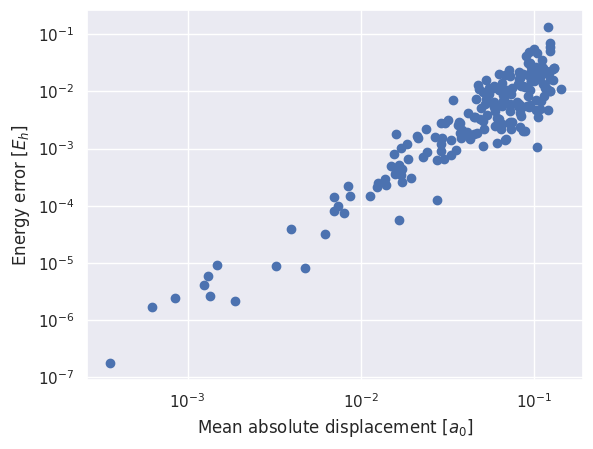

In [6]:
mean_displacement = np.array([np.mean(abs(pos - equilibrium_pos)) for pos in test_positions])
absolute_energy_error = np.array(predicted_energies) - np.array(exact_energies)

plt.scatter(mean_displacement, absolute_energy_error, label="Eigenvector continuation")

plt.xlabel(r"Mean absolute displacement [$a_0$]")
plt.ylabel(r"Energy error [$E_h$]")

plt.yscale("log")
plt.xscale("log")

This is great, it works, and the results make sense!
The more we distort the linear chain from the equilibrium geometry (around which we had our training data), the larger the error we make on the energy.
However, it is not fully clear how good these predictions actually are / what they mean.
To get an idea, we can compare to the Hartree-Fock energies (after all, we have a similar scaling as HF, so whenever our predictions are better we definitely have an edge over running a full HF calculation).

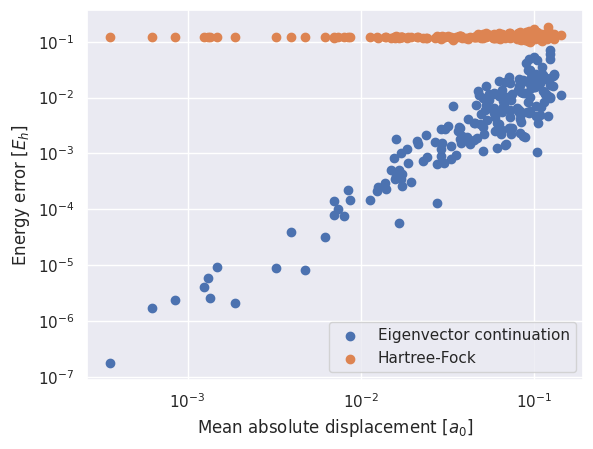

In [7]:
hf_error = np.array(hf_energies) - np.array(exact_energies)
plt.scatter(mean_displacement, absolute_energy_error, label="Eigenvector continuation")
plt.scatter(mean_displacement, hf_error, label="Hartree-Fock")

plt.xlabel(r"Mean absolute displacement [$a_0$]")
plt.ylabel(r"Energy error [$E_h$]")

plt.legend()

plt.yscale("log")
plt.xscale("log")

### Comparing to a (naive) fit of the training data points with SOAP descriptors
The approach to predict the energies above is fully variational, i.e., we will always predict an upper bound on the energy.
Furthermore, the approach does only fit the energy landscape implicitly by obtaining a new wavefunction ansatz from the training states fully deterministically in closed form.
This is quite different from standard approaches to describe the potential energy landscape with machine learning methods from few training examples.
Let's also train a Gaussian process with a kernel function obtained from SOAP features on the energy values of the training set, and add the predicted results to our plot.
The way this is done here is completely naive and can certainly be improved (we'd definitely like to understand how!).
This is not a tutorial on how to fit the potential energy landscape with Gaussian process regressors!

In [45]:
"""
Fitting with a standard GP (no hyperparameter optimization at this point)
"""

""" 
Construct SOAP features for all the atomic clusters in the training set
"""

# The hyperparameters are completely untuned at this stage, 
soap = SOAP(species=["H"], periodic=False, r_cut=10.0, n_max=10, l_max=20)

features = []

# Get the SOAP features
for i, dist in enumerate(trainig_dists):
    h_chain = Atoms("H"*number_atoms, [(x, 0., 0.) for x in dist*np.arange(number_atoms)])
    features.append(soap.create(h_chain))

"""
Create global SOAP average kernel, there are other choices to construct the kernel as
well, which might perform differently.
"""

avg_kernel = AverageKernel(metric="linear")

kernel_mat = avg_kernel.create(features)

np.save("SOAP_kernel.npy", kernel_mat)

# Fitting the GP, we set some rather randomly chosen small noise
noise_term = np.eye(kernel_mat.shape[0]) * 1.e-15
# We only need the weights later on so calling lstsq is enough
weights = np.linalg.lstsq(kernel_mat + noise_term, energies)[0]

/tmp/ipykernel_35144/977864028.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  weights = np.linalg.lstsq(kernel_mat + noise_term, energies)[0]


Adding the GP predictions to the scatterplot above...

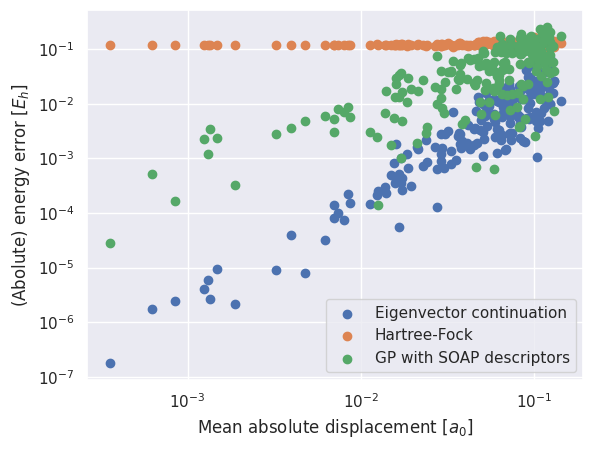

In [46]:
GP_energies = []

for i, config in enumerate(test_positions):
    h_chain = Atoms("H"*number_atoms, [atom_pos for atom_pos in config])
    test_features = avg_kernel.create([soap.create(h_chain)], features)
    GP_energies.append(weights.dot(np.squeeze(test_features)))

GP_error = np.array(GP_energies) - np.array(exact_energies)

plt.scatter(mean_displacement, absolute_energy_error, label="Eigenvector continuation")
plt.scatter(mean_displacement, hf_error, label="Hartree-Fock")
plt.scatter(mean_displacement, abs(GP_error), label="GP with SOAP descriptors")

plt.xlabel(r"Mean absolute displacement [$a_0$]")
plt.ylabel(r"(Abolute) energy error [$E_h$]")

plt.yscale("log")
plt.xscale("log")

plt.legend()

The GP predictions also follow the expected trend: The more we distort the geometry away from the training geometries, the larger the prediction error.
We definitely need a bit more data for the comparison between the approaches (in particular also for the evaluation of gradients/force fields), but so far the results look pretty promising.

## What's next?
We have already verified that the approach also scales to larger systems with DMRG/MPS calculations (and with the GPS) for systems beyond what can be done with FCI.
As such calculations are becoming a little bit more computationally demanding, these are not really suitable to run in a jupyter notebook cell and we just show the results here without the detailed code (but there is nothing special going on as compared to the examples above).
The following plot is similar to the one above but we scan over different box sizes from which the displacements are drawn (and we plot the average *relative* energy error against the edge length).

![](eigenvector_cont_H_chain_mse_sampled_displacements_local_basis.png)

Also going beyond (quasi-)one-dimensional systems which are less suitable for MPS descriptions, we utilized our Gaussian process state representation for a three-dimensional array of $4\times4\times4$ hydrogen atoms where the bonds are symmetrically expanded.
This is pretty much the limit (in terms of system size) of what we can currently do with our code but the results look promising.
The plot below shows the cross section of the potential energy surface for the system continued from $5$ different (very expensive) ground state approximations (presented in the reference above).
One crucial aspect of these calculations is that we have to sample expectation values stochastically and we have found that this requires a bit of care to obtain sensible results.
While no exact values are available for this system, results marked as "DQG" in the plot below (taken from https://aip.scitation.org/doi/figure/10.1063/1.3459059) provide a lower bound to the true ground state energy (albeit often one which is not necessarily great...).

![](EC_output.png)

Overall, the eigenvector continuation also seems to give sensible agreements for larger systems.
This is good news as there is less of a guarantee that this the case with our learned wavefunction which is a global property not constructed from features of local environments.
In the long run, there might also be ways to construct the global wavefunction from products of local contributions (we have done something similar to this before with our GPS).
This could make it possible to transfer descriptions between entirely different systems and build a full wavefunction from partial states over local environments, in spirit similar to SOAP-style descriptions.
However, this is definitely well beyond the scope at the moment and it is not our focus.

As a next step, a main target is to compare the energy gradients/force fields which we get from the eigenvector continuation.
This should be relatively easy to implement (by utilizing the gradients of the one- and two-electron integrals in the formalism above).
With that we can do full molecular dynamics simulations and geometry optimizations - explicitly targeting the high accuracy/small system limit.

In the long run, we would definitely like to find ways around the $O[N^5]$ scaling of the method, which requires an approach to construct the one- and two-electron integrals more efficiently.
If and how suitable approximations could be employed for this/how these quantities could be learned is not clear at this stage.

We definitely haven't explored the full scope of this project yet.
In general, we are restricted to rather small systems and a comparison to the `traditional' learning of force fields with symmetrically invariant descriptors might not be the best way to present this.


Overall, we are tackling a key problem: Obtaining a quantum state approximation with variational techniques is usually expensive and ways to smoothly interpolate found solutions between different physical regimes (without having to re-run variational calculations) are desirable.
The approach as described above also works for other systems, and the only general conceptual requirement is that the Hamiltonian is linear in its system parameter(s) among which we want to interpolate.
We have already applied the technique to 1D Hubbard chains, and 2D $J_1$-$J_2$ models (for which the evaluation of energies is significantly cheaper).
In both cases the continuation between few training points worked well, giving a mostly consistent error across the parameter space in the vicinity of the training points.
But the main question remains: What more can we do with this?